In [1]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from lifelines.statistics import proportional_hazard_test
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load Data Sources into Pandas Dataframes

In [2]:
# Iimori et al. data set
df_iimori = pd.read_excel('iimori_et_al/ROUTE_proteinuria_dataset.xlsx')

C:\Users\zdana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# Initial View of the Iimori et al. Dataset

In [3]:
df_iimori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           1138 non-null   int64  
 1   gender                       1138 non-null   int64  
 2   age                          1138 non-null   int64  
 3   SBP                          1120 non-null   float64
 4   BMI                          1001 non-null   float64
 5   etiology of CKD              1138 non-null   int64  
 6   Hb                           1136 non-null   float64
 7   Alb                          1126 non-null   float64
 8   Cr                           1138 non-null   float64
 9   eGFR                         1138 non-null   float64
 10  CKD_stage                    1138 non-null   int64  
 11  CKD category                 1050 non-null   float64
 12  dip-stick proteinuria        1122 non-null   float64
 13  proteinuria       

# Format Features Dataframe for Base Cox Proportional Hazards Regression

In [4]:
# impute mean for NaN values
df_iimori_CPH = df_iimori.fillna(df_iimori.mean())

CPH_features = [
    "ID",
    "gender",
    "age",
    "SBP",
    "BMI",
    "etiology of CKD",
    "Hb",
    "Alb",
    "Cr",
    "eGFR",
    "CKD_stage",
    "CKD category",
    "dip-stick proteinuria",
    "proteinuria",
    "urinary occult blood",
    "UPCR",
    "UPCR category",
    "hypertension",
    "prevalence of CVD",
    "diabetes",
    "use of RAASi",
    "use of CCB",
    "use of diuretics",
    "CKD progression",
    "CKD progression_duration",
    "eGFR(0M)",
    "eGFR(6M)",
    "50%eGFR_reached(6M)",
    "eGFR(12M)",
    "50%eGFR_reached(12M)",
    "eGFR(18M)",
    "50%eGFR1_reached(18M)",
    "eGFR(24M)",
    "50%eGFR_reached(24M)",
    "eGFR(30M)",
    "50%eGFR_reached(30M)",
    "eGFR(36M)",
    "50%eGFR_reached(36M)",
    "eGFR(last visit)"
]

df_CPH = df_iimori_CPH[CPH_features]
df_CPH.reset_index(drop=True)

,ID,gender,age,SBP,BMI,etiology of CKD,Hb,Alb,Cr,eGFR,...,50%eGFR_reached(12M),eGFR(18M),50%eGFR1_reached(18M),eGFR(24M),50%eGFR_reached(24M),eGFR(30M),50%eGFR_reached(30M),eGFR(36M),50%eGFR_reached(36M),eGFR(last visit)
0,10101,2,74,120.0,23.137669,2,12.0,4.0,1.20,34.146986,...,0.000000,24.682189,0.000000,21.614854,0.000000,20.420524,0.000000,18.495328,0.000000,18.495328
1,10102,1,39,121.0,31.708284,3,15.0,4.7,1.31,50.451187,...,0.044665,34.127299,0.050562,32.820600,0.077508,33.248608,0.104096,33.817914,0.097701,50.451187
2,10103,1,74,143.0,24.554564,2,10.9,3.8,4.95,9.804696,...,0.000000,34.127299,0.050562,32.820600,0.077508,33.248608,0.104096,33.817914,0.097701,5.578057
3,10201,1,57,139.0,28.515625,2,15.9,4.8,0.84,73.570568,...,0.000000,72.845992,0.000000,71.908942,0.000000,71.562914,0.000000,67.225032,0.000000,67.225032
4,10202,1,32,154.0,24.582701,4,14.4,4.4,0.87,83.558305,...,0.000000,68.856399,0.000000,72.901926,0.000000,69.749275,0.000000,69.171408,0.000000,69.171408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,160109,2,71,179.0,20.487647,2,9.9,4.2,1.90,20.901554,...,0.044665,34.127299,0.050562,32.820600,0.077508,33.248608,0.104096,33.817914,0.097701,20.901554
1134,160110,2,62,139.0,19.992311,1,11.8,4.0,4.74,7.993339,...,0.000000,6.694902,0.000000,6.109193,0.000000,5.459988,0.000000,4.664378,0.000000,4.664378
1135,160111,1,60,118.0,27.584219,2,14.6,4.2,1.42,40.819612,...,0.000000,45.511836,0.000000,45.299938,0.000000,47.953885,0.000000,41.861876,0.000000,41.861876
1136,160112,1,52,94.0,21.295295,4,13.5,4.3,2.13,27.293642,...,0.000000,27.713700,0.000000,28.004897,0.000000,26.455610,0.000000,28.931595,0.000000,28.931595


# Format Features Dataframe for Minimal Cox Proportional Hazards Regression

In [5]:
CPH_minimal_features = [
    "ID",
    "gender",
    "age",
    "SBP",
    "BMI",
    "etiology of CKD",
    "Hb",
    "Alb",
    "Cr",
    "eGFR",
    "CKD_stage",
    "CKD category",
    "dip-stick proteinuria",
    "proteinuria",
    "urinary occult blood",
    "UPCR",
    "UPCR category",
    "hypertension",
    "prevalence of CVD",
    "diabetes",
    "use of RAASi",
    "use of CCB",
    "use of diuretics",
    "CKD progression",
    "CKD progression_duration",
    "eGFR(0M)",
    "eGFR(last visit)"
]

df_CPH_minimal = df_iimori_CPH[CPH_minimal_features]
df_CPH_minimal.reset_index(drop=True)

,ID,gender,age,SBP,BMI,etiology of CKD,Hb,Alb,Cr,eGFR,...,hypertension,prevalence of CVD,diabetes,use of RAASi,use of CCB,use of diuretics,CKD progression,CKD progression_duration,eGFR(0M),eGFR(last visit)
0,10101,2,74,120.0,23.137669,2,12.0,4.0,1.20,34.146986,...,1,0,0,1,1,0,0,37,34.146986,18.495328
1,10102,1,39,121.0,31.708284,3,15.0,4.7,1.31,50.451187,...,1,0,0,0,0,0,0,1,50.451187,50.451187
2,10103,1,74,143.0,24.554564,2,10.9,3.8,4.95,9.804696,...,1,0,1,1,1,1,1,13,9.804696,5.578057
3,10201,1,57,139.0,28.515625,2,15.9,4.8,0.84,73.570568,...,1,0,0,0,0,0,0,37,73.570568,67.225032
4,10202,1,32,154.0,24.582701,4,14.4,4.4,0.87,83.558305,...,1,0,0,0,0,0,0,36,83.558305,69.171408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,160109,2,71,179.0,20.487647,2,9.9,4.2,1.90,20.901554,...,1,0,0,0,0,0,0,1,20.901554,20.901554
1134,160110,2,62,139.0,19.992311,1,11.8,4.0,4.74,7.993339,...,1,1,1,1,1,0,0,36,7.993339,4.664378
1135,160111,1,60,118.0,27.584219,2,14.6,4.2,1.42,40.819612,...,1,0,0,1,1,0,0,38,40.819612,41.861876
1136,160112,1,52,94.0,21.295295,4,13.5,4.3,2.13,27.293642,...,1,0,0,1,0,0,0,36,27.293642,28.931595


# Fit Base Cox Proportional Hazards Model

In [6]:
# Split dataset into test and train partitions
train, test = train_test_split(df_CPH, test_size=0.2, random_state=42)  # 20% of the data is used for testing

# fit the cox proportional hazards analysis model
cph = CoxPHFitter(penalizer=0.1)
cph.fit(train, duration_col='CKD progression_duration', event_col='CKD progression', show_progress=True)

Iteration 1: norm_delta = 1.62e+00, step_size = 0.9500, log_lik = -1327.40926, newton_decrement = 4.64e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.64e+00, step_size = 0.9500, log_lik = -1250.41926, newton_decrement = 5.09e+02, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.15e+00, step_size = 0.9500, log_lik = -1135.06444, newton_decrement = 2.35e+02, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.95e+00, step_size = 0.9310, log_lik = -1348.06969, newton_decrement = 1.22e+03, seconds_since_start = 0.0
Iteration 5: norm_delta = 4.67e+00, step_size = 0.9124, log_lik = -1920.87756, newton_decrement = 1.02e+03, seconds_since_start = 0.0
Iteration 6: norm_delta = 3.08e+00, step_size = 0.8941, log_lik = -1194.28762, newton_decrement = 7.09e+02, seconds_since_start = 0.0
Iteration 7: norm_delta = 3.57e+00, step_size = 1.0000, log_lik = -1500.30747, newton_decrement = 5.98e+02, seconds_since_start = 0.0
Iteration 8: norm_delta = 5.11e+00, step_size = 0.9800, log_li

<lifelines.CoxPHFitter: fitted with 910 total observations, 701 right-censored observations>

# Examine Feature Importances

In [7]:
# Print the summary of the model to see the impact of each covariate
display(cph.summary)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
ID,-0.000002,0.999998,0.000002,-0.000005,0.000001,0.999995,1.000001,0.0,-1.240176,2.149104e-01,2.218193
gender,-0.062786,0.939144,0.133528,-0.324496,0.198924,0.722891,1.220089,0.0,-0.470211,6.382044e-01,0.647910
age,0.003184,1.003189,0.004815,-0.006253,0.012622,0.993767,1.012702,0.0,0.661326,5.084034e-01,0.975954
SBP,0.003333,1.003339,0.002826,-0.002207,0.008873,0.997796,1.008912,0.0,1.179265,2.382927e-01,2.069193
BMI,-0.004636,0.995375,0.015359,-0.034740,0.025468,0.965857,1.025795,0.0,-0.301840,7.627743e-01,0.390672
etiology of CKD,-0.071002,0.931460,0.068946,-0.206134,0.064131,0.813724,1.066232,0.0,-1.029811,3.030987e-01,1.722141
Hb,-0.104450,0.900820,0.033121,-0.169366,-0.039535,0.844200,0.961236,0.0,-3.153631,1.612529e-03,9.276459
Alb,-0.273009,0.761086,0.115877,-0.500125,-0.045894,0.606455,0.955143,0.0,-2.356019,1.847198e-02,5.758518
Cr,0.341237,1.406687,0.044702,0.253623,0.428851,1.288686,1.535492,0.0,7.633638,2.282208e-14,45.316563


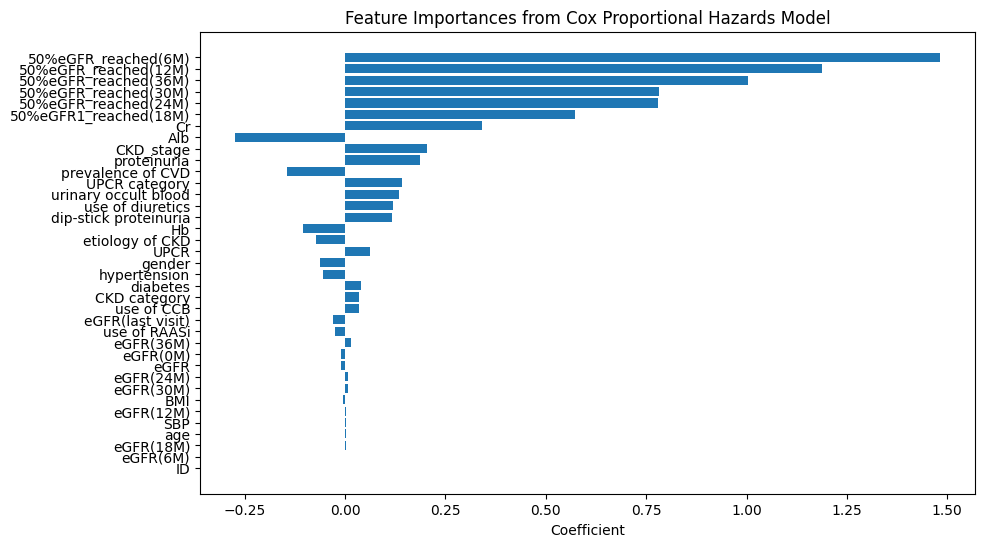

In [8]:
# Extract the coefficients and their corresponding feature names
coefficients = cph.params_
feature_importances = pd.DataFrame({
    'Feature': coefficients.index,
    'Coefficient': coefficients.values
})

# Sort the features by the absolute value of the coefficients
feature_importances['Abs_Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Feature Importances from Cox Proportional Hazards Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

# Validate the Cox Proportional Hazards Model on Test Set

In [9]:
# Assess the predictive performance using concordance index
c_index_train = cph.concordance_index_
print("Concordance index on training data:", c_index_train)

c_index_test = cph.score(test, scoring_method="concordance_index")
print("Concordance index on test data:", c_index_test)

Concordance index on training data: 0.9566499987843522
Concordance index on test data: 0.917805425249847


In [10]:
# Perform Schoenfeld test to assess the proportional hazards assumption
results = proportional_hazard_test(cph, train, time_transform='rank')
display(results.summary)

,test_statistic,p,-log2(p)
50%eGFR1_reached(18M),1.241340,0.265213,1.914776
50%eGFR_reached(12M),0.060020,0.806464,0.310318
50%eGFR_reached(24M),4.117806,0.042434,4.558632
50%eGFR_reached(30M),3.851314,0.049707,4.330406
50%eGFR_reached(36M),16.243364,0.000056,14.131850
50%eGFR_reached(6M),3.587155,0.058228,4.102147
Alb,0.012618,0.910561,0.135172
BMI,0.553599,0.456851,1.130205
CKD category,0.166704,0.683058,0.549921
CKD_stage,0.024673,0.875185,0.192340


# Predict and Visualize the Survival Functions

In [11]:
# Predict the survival function for the test set
survival_functions = cph.predict_survival_function(test)

In [12]:
# calculate median survival duration for all survival functions
median_survival_times = survival_functions.apply(lambda x: x.index[x <= 0.5].min() if any(x <= 0.5) else x.index[-1], axis=0)

# sort the median survival times, organizing faster and slower progressing patients
sorted_indices = median_survival_times.sort_values().index

# Select indices: the first, the last, and 8 evenly spaced in between
selected_indices = [
    sorted_indices[0],  # Fastest progression
    sorted_indices[-1]  # Slowest progression
] + list(sorted_indices[np.linspace(1, len(sorted_indices) - 2, 8, dtype=int)])  # Evenly spaced

# Sort by median survival time
sorted_indices = median_survival_times.sort_values().index

# Select indices: the first, the last, and 8 evenly spaced in between
selected_indices = [
    sorted_indices[0],  # Fastest progression
    sorted_indices[-1]  # Slowest progression
] + list(sorted_indices[np.linspace(1, len(sorted_indices) - 2, 10, dtype=int)])  # Evenly spaced

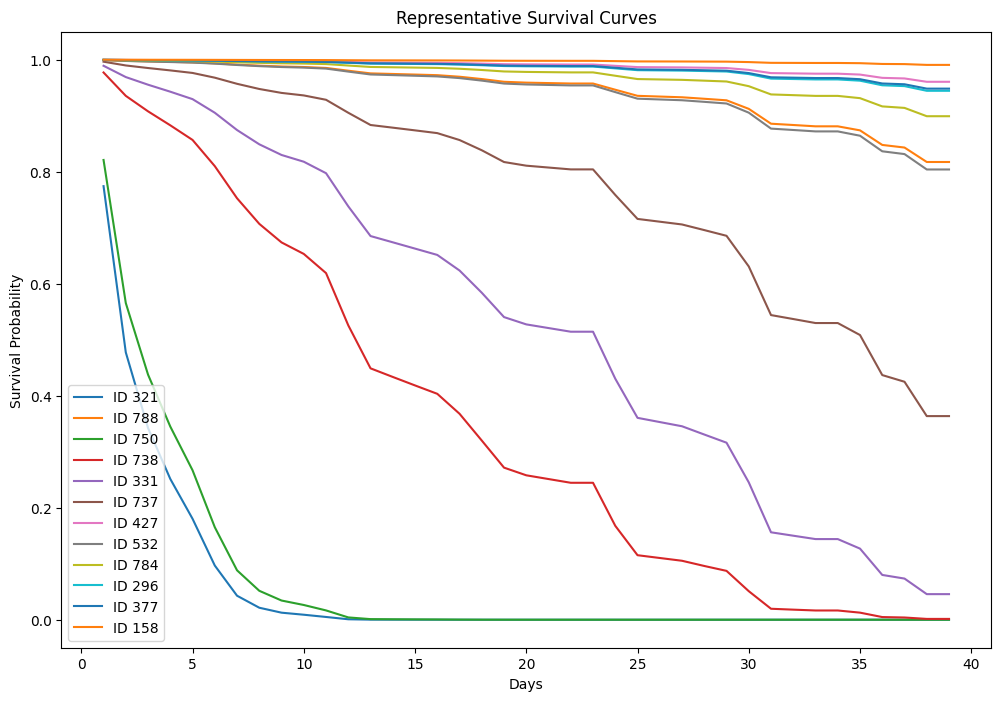

In [13]:
plt.figure(figsize=(12, 8))
for idx in selected_indices:
    plt.plot(survival_functions.index, survival_functions[idx], label=f'ID {idx}')

plt.title('Representative Survival Curves')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

# Fit Minimal Cox Proportional Hazards Model

In [14]:
# Split dataset into test and train partitions
train_min, test_min = train_test_split(df_CPH_minimal, test_size=0.2, random_state=42)  # 20% of the data is used for testing

# fit the cox proportional hazards analysis model
cph_minimal = CoxPHFitter(penalizer=0.1)
cph_minimal.fit(train_min, duration_col='CKD progression_duration', event_col='CKD progression', show_progress=True)

Iteration 1: norm_delta = 1.28e+00, step_size = 0.9500, log_lik = -1327.40926, newton_decrement = 3.12e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.80e-01, step_size = 0.9500, log_lik = -1091.44001, newton_decrement = 4.44e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 9.60e-02, step_size = 0.9500, log_lik = -1046.27065, newton_decrement = 1.11e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.71e-03, step_size = 1.0000, log_lik = -1045.12602, newton_decrement = 3.59e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.08e-05, step_size = 1.0000, log_lik = -1045.12242, newton_decrement = 4.66e-08, seconds_since_start = 0.0
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 910 total observations, 701 right-censored observations>

# Examine Feature Importances

In [15]:
# Print the summary of the model to see the impact of each covariate
display(cph_minimal.summary)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
ID,-0.000003,0.999997,0.000001,-0.000005,3.115942e-07,0.999995,1.000000,0.0,-1.745390,8.091703e-02,3.627413
gender,-0.090065,0.913872,0.128999,-0.342897,1.627676e-01,0.709711,1.176763,0.0,-0.698185,4.850613e-01,1.043761
age,-0.000079,0.999921,0.004694,-0.009279,9.121469e-03,0.990764,1.009163,0.0,-0.016816,9.865835e-01,0.019487
SBP,0.003328,1.003334,0.002624,-0.001815,8.471562e-03,0.998187,1.008508,0.0,1.268426,2.046457e-01,2.288800
BMI,-0.008115,0.991918,0.015280,-0.038064,2.183406e-02,0.962652,1.022074,0.0,-0.531061,5.953762e-01,0.748126
etiology of CKD,-0.134831,0.873864,0.067018,-0.266183,-3.478228e-03,0.766299,0.996528,0.0,-2.011864,4.423426e-02,4.498692
Hb,-0.096256,0.908231,0.032036,-0.159045,-3.346675e-02,0.852958,0.967087,0.0,-3.004627,2.659068e-03,8.554863
Alb,-0.460581,0.630917,0.108833,-0.673890,-2.472714e-01,0.509722,0.780929,0.0,-4.231986,2.316368e-05,15.397776
Cr,0.334161,1.396768,0.043208,0.249474,4.188480e-01,1.283350,1.520209,0.0,7.733706,1.044604e-14,46.444037


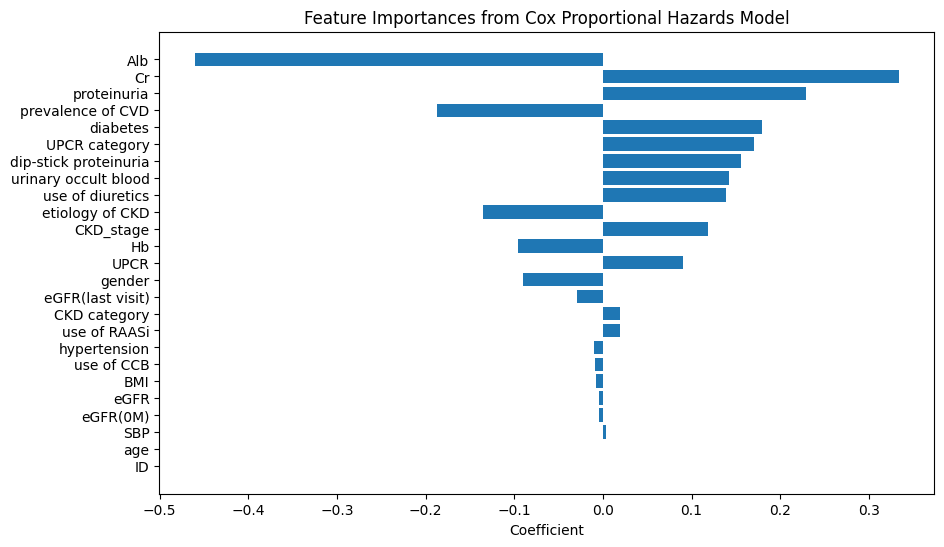

In [16]:
# Extract the coefficients and their corresponding feature names
coefficients = cph_minimal.params_
feature_importances = pd.DataFrame({
    'Feature': coefficients.index,
    'Coefficient': coefficients.values
})

# Sort the features by the absolute value of the coefficients
feature_importances['Abs_Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Feature Importances from Cox Proportional Hazards Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

# Validate the Minimal Cox Proportional Hazards Model on Test Set

In [17]:
# Assess the predictive performance using concordance index
c_index_train = cph_minimal.concordance_index_
print("Concordance index on training data:", c_index_train)

c_index_test = cph_minimal.score(test_min, scoring_method="concordance_index")
print("Concordance index on test data:", c_index_test)

Concordance index on training data: 0.9247270870646968
Concordance index on test data: 0.8786457271058535
